# Hierarchical Bayesian neural networks

Code is based on  [This blog post](https://twiecki.io/blog/2018/08/13/hierarchical_bayesian_neural_network/) by Thomas Wiecki.
[Original PyMC3 Notebook](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network_hierarchical.ipynb). Converted to Blackjax by Aleyna Kara (@karalleyna) and Kevin Murphy (@murphyk). (For a Numpyro version, see [here](https://github.com/probml/probml-notebooks/blob/main/notebooks/bnn_hierarchical_numpyro.ipynb).)

We create T=18 different versions of the "two moons" dataset, each rotated by a different amount. These correspond to T different nonlinear binary classification "tasks" that we have to solve. We only get 50 samples from each each task, so solving them separately (with T independent multi layer perceptrons) will result in poor performance. If we pool all the data, and fit a single MLP, we also get poor performance. But if we use a hierarchical Bayesian model, with one MLP per task, and one learned prior MLP,  we will get better results, as we will see.






## Setup

In [ ]:
!pip install blackjax
!pip install distrax

In [ ]:
from warnings import filterwarnings

import jax
from jax import vmap, jit
import jax.numpy as jnp
from jax.random import PRNGKey, split, normal
import jax.random as random
import numpy as np

import blackjax.nuts as nuts
import blackjax.stan_warmup as stan_warmup

import distrax
import tensorflow_probability.substrates.jax.distributions as tfd

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

filterwarnings('ignore')
sns.set_style('white')

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

## Data

We create T=18 different versions of the "two moons" dataset, each rotated by a different amount. These correspond to T different binary classification "tasks" that we have to solve. 


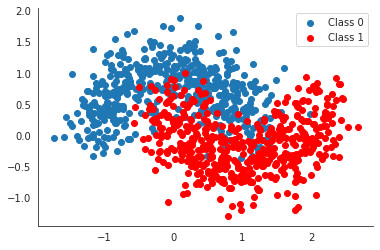

In [ ]:
X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); plt.legend();

In [ ]:

n_groups = 18 

n_grps_sq = int(np.sqrt(n_groups))
n_samples = 100

In [ ]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)
    
    return np.asarray(X)

In [ ]:
np.random.seed(31)

Xs, Ys = [], []
for i in range(n_groups):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)
    
    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)

In [ ]:
Xs = jnp.stack(Xs)
Ys = jnp.stack(Ys)

Xs_train = Xs[:, :n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2:, :]
Ys_train = Ys[:, :n_samples // 2]
Ys_test = Ys[:, n_samples // 2:]

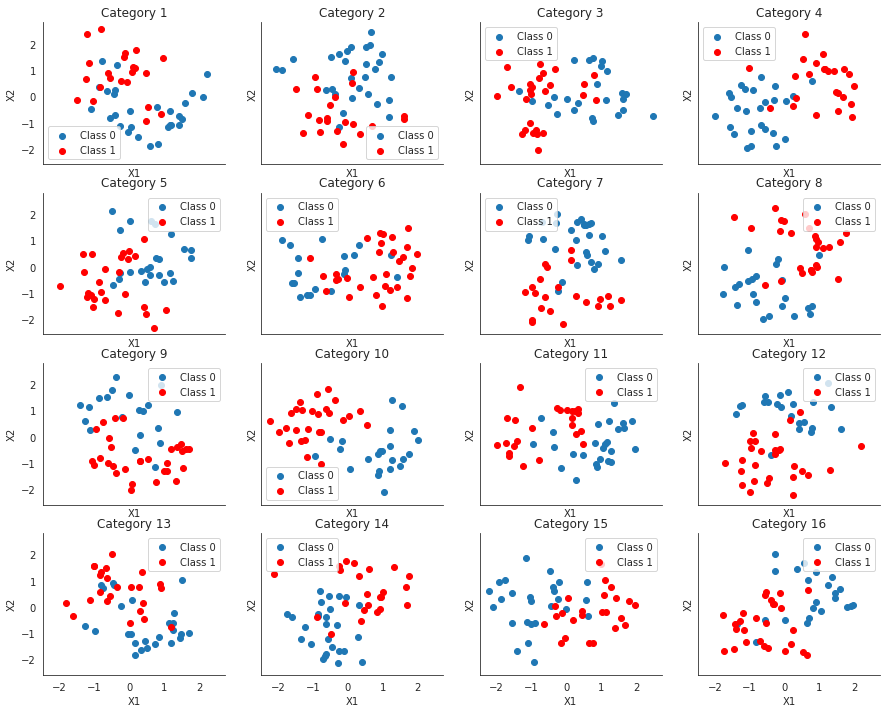

In [ ]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
    ax.set(title='Category {}'.format(i + 1), xlabel='X1', ylabel='X2')

In [ ]:
grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid_3d = jnp.repeat(grid[None, ...], n_groups, axis=0)

## Utility functions for training and testing

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [ ]:
def get_predictions(model, samples, X, n_hidden_layers, rng_key, num_samples):
  samples_flattened, tree_def = jax.tree_flatten(samples)
  keys = random.split(rng_key, num_samples)
  predictions = []
  
  for i, key in enumerate(keys):
    params = {}
    for j, k in enumerate(samples.keys()):
      params[k] = samples_flattened[j][i]

    z = model(params, X, n_hidden_layers)
    Y = distrax.Bernoulli(logits=z).sample(seed=key)
    predictions.append(Y[None, ...])

  return jnp.vstack(predictions)

In [ ]:
def get_mean_predictions(predictions, threshold=0.5):
  # compute mean prediction and confidence interval around median
  mean_prediction = jnp.mean(predictions, axis=0)
  return mean_prediction > threshold

In [ ]:
def fit_and_eval(rng_key, model, potential_fn, X_train, Y_train, X_test, grid, n_groups=None):
    init_key, warmup_key, inference_key, train_key, test_key, grid_key = split(rng_key, 6)
    
    # initialization
    potential = partial(potential_fn, X=X_train, Y=Y_train, model=model, n_hidden_layers=n_hidden_layers)
    initial_position = init_bnn_params(layer_widths, init_key) if n_groups is None else init_hierarchical_params(layer_widths, n_groups, init_key) 
    initial_state = nuts.new_state(initial_position, potential)
    
    kernel_generator = lambda step_size, inverse_mass_matrix: nuts.kernel(potential, step_size, inverse_mass_matrix)
    
    # warm up
    final_state, (step_size, inverse_mass_matrix), info = stan_warmup.run(
        warmup_key,
        kernel_generator,
        initial_state,
        num_warmup)
        
    # inference
    nuts_kernel = jax.jit(nuts.kernel(potential, step_size, inverse_mass_matrix))
    states = inference_loop(inference_key, nuts_kernel, initial_state, num_samples)
    samples = states.position
    
    # evaluation
    predictions = get_predictions(model, samples, X_train, n_hidden_layers , train_key, num_samples)
    Y_pred_train = get_mean_predictions(predictions)

    predictions = get_predictions(model, samples, X_test, n_hidden_layers, test_key, num_samples)
    Y_pred_test = get_mean_predictions(predictions)

    pred_grid = get_predictions(model, samples, grid, n_hidden_layers, grid_key, num_samples)

    return Y_pred_train, Y_pred_test, pred_grid

## Hyperparameters

We use an MLP with 2 hidden layers, each with 5 hidden units.


In [ ]:
# MLP params
layer_widths = [Xs_train.shape[-1], 5, 5, 1]
n_hidden_layers = len(layer_widths) - 2

In [ ]:
# MCMC params

num_warmup = 1000
num_samples = 500 


## Fit separate MLPs, one per task

Let $w_{tijl}$ be  the weight for node $i$ to node $j$ in layer $l$ in task $t$. We assume
$$
w_{tijl} \sim N(0,1) 
$$
and compute the posterior for all the weights.


In [ ]:
def init_bnn_params(layer_widths, rng_key):
  rng_key, *keys = split(rng_key, len(layer_widths))
  params = {}
  
  for i, (n_in, n_out, key) in enumerate(zip(layer_widths[:-1], layer_widths[1:], keys)):
    params[f"w_{i}"] = distrax.Normal(0,1).sample(seed=key, sample_shape=(n_in, n_out))
  
  return params


In [ ]:
def bnn(params, X, n_hidden_layers):
    z = X
    
    for i in range(n_hidden_layers + 1):
      z = z @ params[f"w_{i}"]
      z = jax.nn.tanh(z) if i != n_hidden_layers else z

    z = z.squeeze(-1)
    return z

In [ ]:
def potential_fn_of_bnn(params, X, Y, model, n_hidden_layers):
    log_joint = 0

    for i in range(n_hidden_layers + 1):
        log_joint += distrax.Normal(0., 1.).log_prob(params[f"w_{i}"]).sum()
    
    z = model(params, X, n_hidden_layers)
    loglikelihood = distrax.Bernoulli(logits=z).log_prob(Y).sum()
    log_joint += loglikelihood
 
    return -jnp.sum(log_joint)

In [ ]:
rng_key = PRNGKey(0)
keys = split(rng_key, n_groups)

def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
  return fit_and_eval(key, bnn, potential_fn_of_bnn, X_train, Y_train, X_test, grid, n_groups=None)

Ys_pred_train, Ys_pred_test, ppc_grid_single = vmap(fit_and_eval_single_mlp)(keys, Xs_train, Ys_train, Xs_test)

### Results

Accuracy is reasonable, but the decision boundaries are nearly linear (thanks to the Bayes Occam's razor effect), and have not captured the underlying Z pattern in the data, due to having too little data per task.

In [ ]:
print ("Train accuracy = {:.2f}%".format(100*jnp.mean(Ys_pred_train == Ys_train)))

Train accuracy = 86.78%


In [ ]:
print ("Test accuracy = {:.2f}%".format(100*jnp.mean(Ys_pred_test == Ys_test)))

Test accuracy = 83.33%


In [ ]:
def plot_decision_surfaces_non_hierarchical(nrows=2, ncols=2):
  fig, axes = plt.subplots(figsize=(15, 12), nrows=nrows, ncols=ncols, sharex=True, sharey=True)
  axes = axes.flatten()
  for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axes)):
      contour = ax.contourf(grid[:, 0].reshape(100, 100), grid[:, 1].reshape(100, 100), ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
      ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
      ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
      sns.despine(); ax.legend()

Below we show that the decision boundaries do not look reasonable, since there is not enough data to fit each model separately.


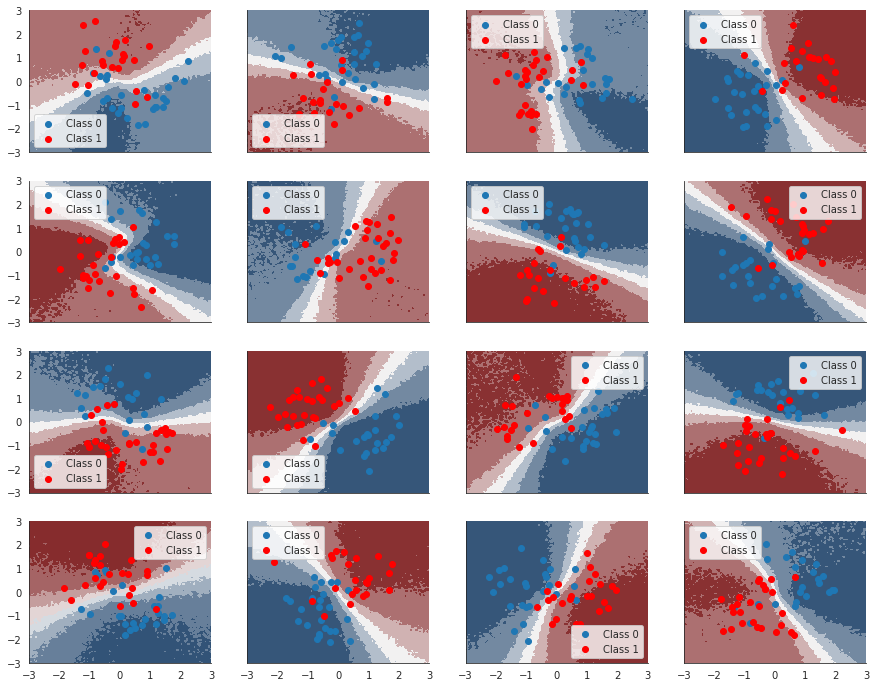

In [ ]:
plot_decision_surfaces_non_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)

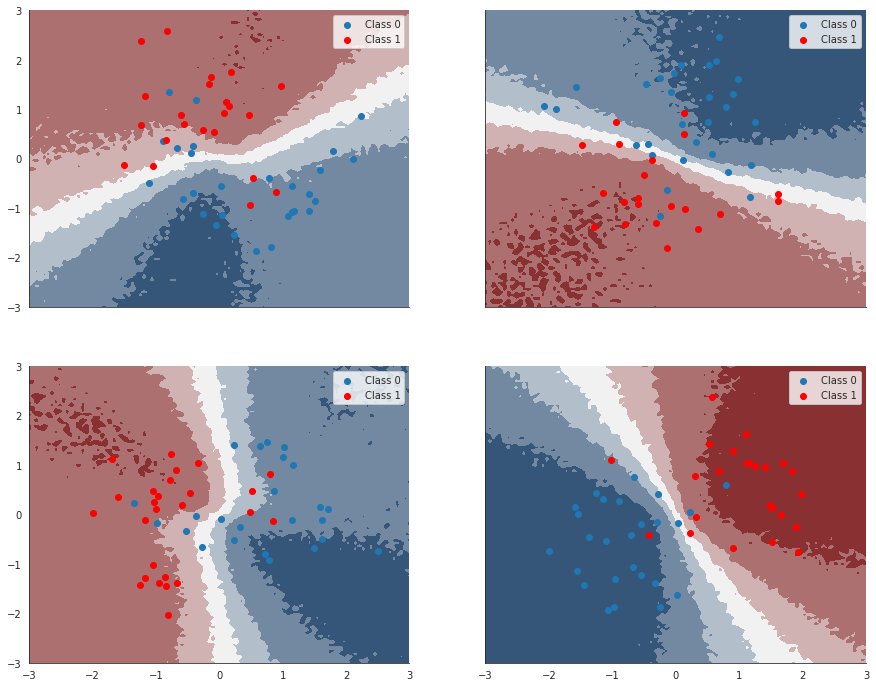

In [ ]:
plot_decision_surfaces_non_hierarchical()

## Hierarchical Model

Now we use a hierarchical Bayesian model, which has a common Gaussian prior for all the weights, but allows each task to have its own task-specific parameters. More precisely, let $w_{tijl}$ be  the weight for node $i$ to node $j$ in layer $l$ in task $t$. We assume
$$
w_{tijl} \sim N(\mu_{ijl}, \sigma_l) 
$$

$$
\mu_{ijl} \sim N(0,1) 
$$

$$
\sigma_l \sim N_+(0,1)
$$

or, in non-centered form,
$$
w_{tijl} = \mu_{ijl} + \epsilon_{tijl} \sigma_l
$$

In [ ]:
def init_hierarchical_params(layer_widths, n_groups, rng_key):
  half_normal = distrax.as_distribution(tfd.HalfNormal(1.0))
  rng_key, *keys = split(rng_key, len(layer_widths))
  params = {}
  for i, (n_in, n_out, key) in enumerate(zip(layer_widths[:-1], layer_widths[1:], keys)):
    mu_key, std_key, eps_key = split(key, 3)
    params[f"w_{i}_mu"] = distrax.Normal(0,1).sample(seed=mu_key, sample_shape=(n_in, n_out))
    params[f"w_{i}_std"] = half_normal.sample(seed=std_key, sample_shape=(1,))
    params[f"w_{i}_eps"] = distrax.Normal(0,1).sample(seed=eps_key, sample_shape=(n_groups, n_in, n_out))
    
  return params

In [ ]:
def hierarchical_model(params, X, n_hidden_layers):
    n_groups, _, input_dim = X.shape
    output_dim = 1

    z = X
    
    for i in range(n_hidden_layers + 1):
      w = params[f"w_{i}_mu"] +  params[f"w_{i}_eps"] * params[f"w_{i}_std"]
      z = z @ w
      z = jax.nn.tanh(z) if i != n_hidden_layers else z

    z = z.squeeze(-1)
    return z

In [ ]:
def potential_fn_of_hierarchical_model(params, X, Y, model, n_hidden_layers):
    log_joint = 0
    half_normal = distrax.as_distribution(tfd.HalfNormal(1.0))
    
    for i in range(n_hidden_layers + 1):
        log_joint += distrax.Normal(0., 1.0).log_prob(params[f"w_{i}_mu"]).sum()
        log_joint += half_normal.log_prob(params[f"w_{i}_std"]).sum()
        log_joint += distrax.Normal(0., 1.).log_prob(params[f"w_{i}_eps"]).sum()
    
    z = hierarchical_model(params, X, n_hidden_layers)
    loglikelihood = distrax.Bernoulli(logits=z).log_prob(Y).sum()
    log_joint += loglikelihood
 
    return -jnp.sum(log_joint)

In [ ]:
rng_key = PRNGKey(0)
Ys_hierarchical_pred_train, Ys_hierarchical_pred_test, ppc_grid = fit_and_eval(rng_key, hierarchical_model, potential_fn_of_hierarchical_model, Xs_train, Ys_train, Xs_test, grid_3d, n_groups=n_groups)

### Results

We see that the train and test accuracy are higher, and the decision boundaries all have the shared "Z" shape, as desired.


In [ ]:
print ("Train accuracy = {:.2f}%".format(100*jnp.mean(Ys_hierarchical_pred_train == Ys_train)))

Train accuracy = 90.56%


In [ ]:
print ("Test accuracy = {:.2f}%".format(100*jnp.mean(Ys_hierarchical_pred_test == Ys_test)))

Test accuracy = 88.89%


In [ ]:
def plot_decision_surfaces_hierarchical(nrows=2, ncols=2):
  fig, axes = plt.subplots(figsize=(15, 12), nrows=nrows, ncols=ncols, sharex=True, sharey=True)

  for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axes.flatten())):
      contour = ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid[:, i, :].mean(axis=0).reshape(100, 100), cmap=cmap)
      ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
      ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
      sns.despine(); ax.legend()

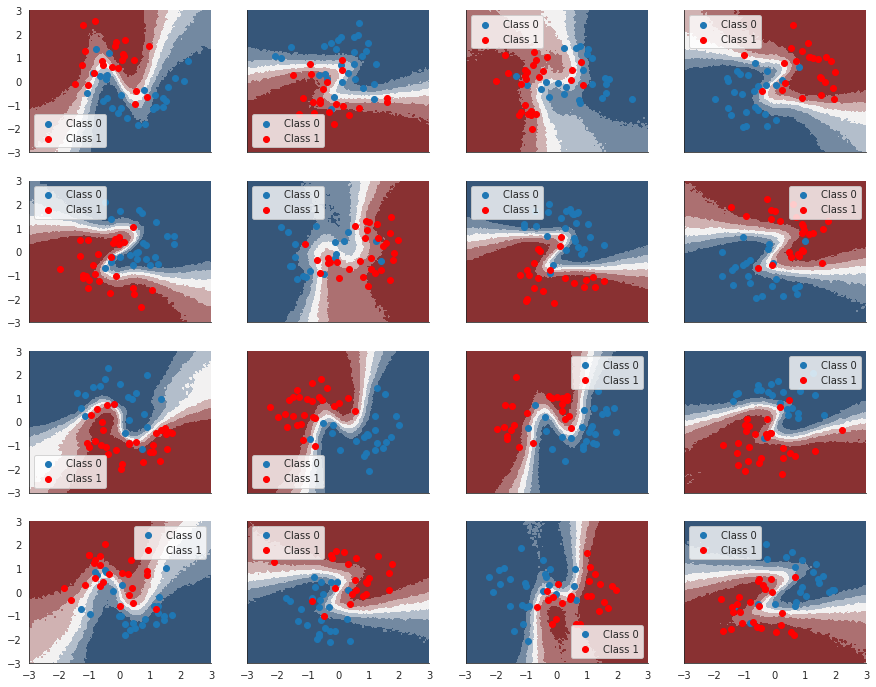

In [ ]:
plot_decision_surfaces_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)

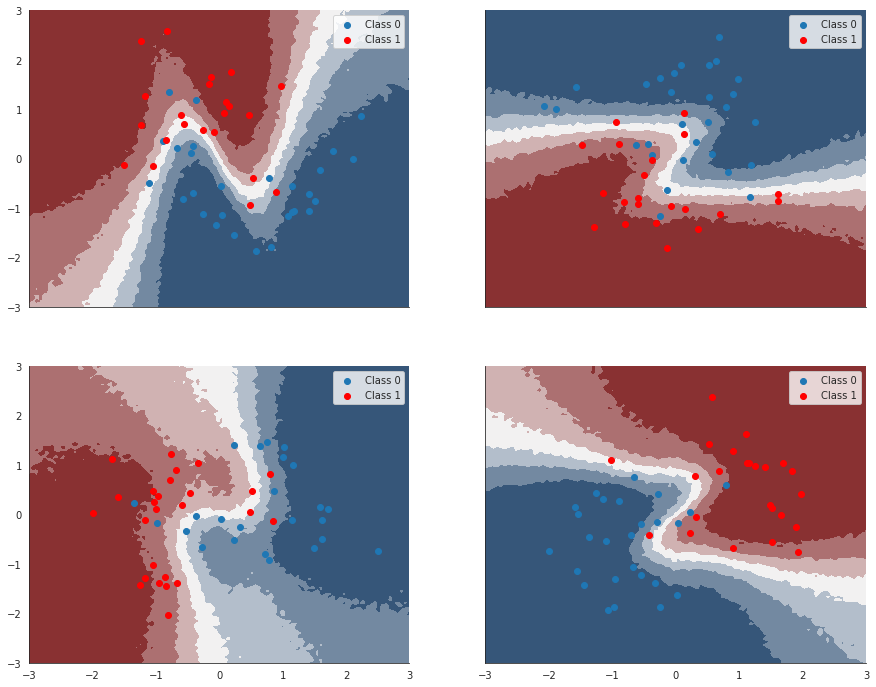

In [ ]:
plot_decision_surfaces_hierarchical()